In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from habr_article_analyzer import data, data_loader
from habr_article_analyzer.data import DEFAULT_FULL_PATH
from habr_article_analyzer.settings import settings

# Exploratory data analysis. Data visualization.

*Author: Nikita Zolin*

**Remark.** Our main task in this project is to predict a hub based on the part of the text. We will not use any information about the article such as date, author, etc. However, we still analyse such fields just to understand the data better.

**Remark 2.** We can't keep the whole dataset in memory since it's too large. We will use `HabrDataset` which allows to fetch only light-weight columns.

## Numerical columns basic analysis

For the first section let's stick to the numerical columns such as statistics, reading_time and etc.

In [2]:
data.download_dataset(DEFAULT_FULL_PATH)

In [3]:
columns_to_load = ["id", "title", "text_markdown", "author", "statistics"]

dataset = data_loader.HabrDataset(
    path=DEFAULT_FULL_PATH, columns=columns_to_load, batch_size=50_000
)

all_batches = []
for batch_df in dataset:
    batch_df["title_length"] = batch_df["title"].str.len()
    batch_df["text_length"] = batch_df["text_markdown"].str.len()
    batch_df = batch_df.drop(columns=["title", "text_markdown"])

    stats_df = batch_df["statistics"].apply(pd.Series)
    stats_df = stats_df.rename(columns=lambda x: f"stats_{x}")

    batch_df = pd.concat([batch_df.drop(columns=["statistics"]), stats_df], axis=1)

    all_batches.append(batch_df)

full_df = pd.concat(all_batches, ignore_index=True)
full_df.head()

Reading dataset: 302049it [02:42, 1856.97it/s]


,id,author,title_length,text_length,stats_commentsCount,stats_favoritesCount,stats_readingCount,stats_score,stats_votesCount,stats_votesCountPlus,stats_votesCountMinus
0,12730,Юлия Благовещенская (skazala),41,608,23,1,1542,7,15,11,4
1,558542,mobileSimbirSoft,55,10237,3,17,7229,6,6,6,0
2,141150,Анатолий Ализар (alizar),62,1830,10,22,1711,20,24,22,2
3,530546,SearchInform_team,95,6698,1,7,2737,8,8,8,0
4,598357,Никита Цаплин (ntsaplin),82,9667,101,78,35519,79,83,81,2


Let's look at some basic statistics.

In [4]:
full_df.describe()

,id,title_length,text_length,stats_commentsCount,stats_favoritesCount,stats_readingCount,stats_score,stats_votesCount,stats_votesCountPlus,stats_votesCountMinus
count,302049.000000,302049.000000,302049.000000,302049.000000,302049.000000,3.020490e+05,302049.000000,302049.000000,302049.000000,302049.000000
mean,324681.610898,53.539644,7449.095379,33.553417,52.640207,1.853326e+04,21.879023,37.642028,29.759244,7.880221
std,210431.252045,23.917111,9124.073436,67.451564,115.584833,4.383586e+04,32.902461,547.708788,275.350250,273.333629
min,1.000000,1.000000,5.000000,0.000000,0.000000,5.900000e+01,-194.000000,0.000000,-20.000000,-39.000000
25%,131406.000000,36.000000,1876.000000,4.000000,5.000000,2.112000e+03,5.000000,11.000000,8.000000,1.000000
50%,318104.000000,51.000000,4797.000000,13.000000,20.000000,6.944000e+03,12.000000,20.000000,16.000000,3.000000
75%,498800.000000,69.000000,9985.000000,36.000000,56.000000,1.830800e+04,27.000000,40.000000,33.000000,7.000000
max,716000.000000,219.000000,773489.000000,2928.000000,9260.000000,5.591725e+06,1448.000000,65535.000000,32767.000000,32767.000000


We can see that for some columns `mean` is closer to `q3` instead of `q2`, which may signal about heavy tail. We also see that `median` article has quite a lot of comments and readings.

We also see some suspicious statistics. For example:

1) Negative values in `stats_votesCountPlus` and `stats_votesCountMinus`. We believe that they can't be negative so we need to handle them.
2) `2**15 - 1` in the same columns. It might be the result of the clamp, which we also don't know how to interpolate.

To choose the way to handle such rows let's check the amount of them:

In [5]:
mask_weird = (
    (full_df["stats_votesCountPlus"] < 0)
    | (full_df["stats_votesCountMinus"] < 0)
    | (full_df["stats_votesCountPlus"].astype(np.int64) == 2**15 - 1)
    | (full_df["stats_votesCountMinus"].astype(np.int64) == 2**15 - 1)
)

mask_weird.sum()

np.int64(60)

We see that there are only 60 rows for 300k, so let's just remove them. Here we should keep in mind that such big number can mean that there are more votes and we are removing heavy tails. However, since we can't identify the actual reason, it's better to follow the safe way.

In [6]:
filtered_df = full_df[~mask_weird]

In [7]:
filtered_df.isna().sum()

id                        0
author                   35
title_length              0
text_length               0
stats_commentsCount       0
stats_favoritesCount      0
stats_readingCount        0
stats_score               0
stats_votesCount          0
stats_votesCountPlus      0
stats_votesCountMinus     0
dtype: int64

We have them only in `author` column which means that author was anonymous. We will keep it in mind if we include this column to our analysis, but for now let's get back to numerical columns.

Let's start with pairplot.

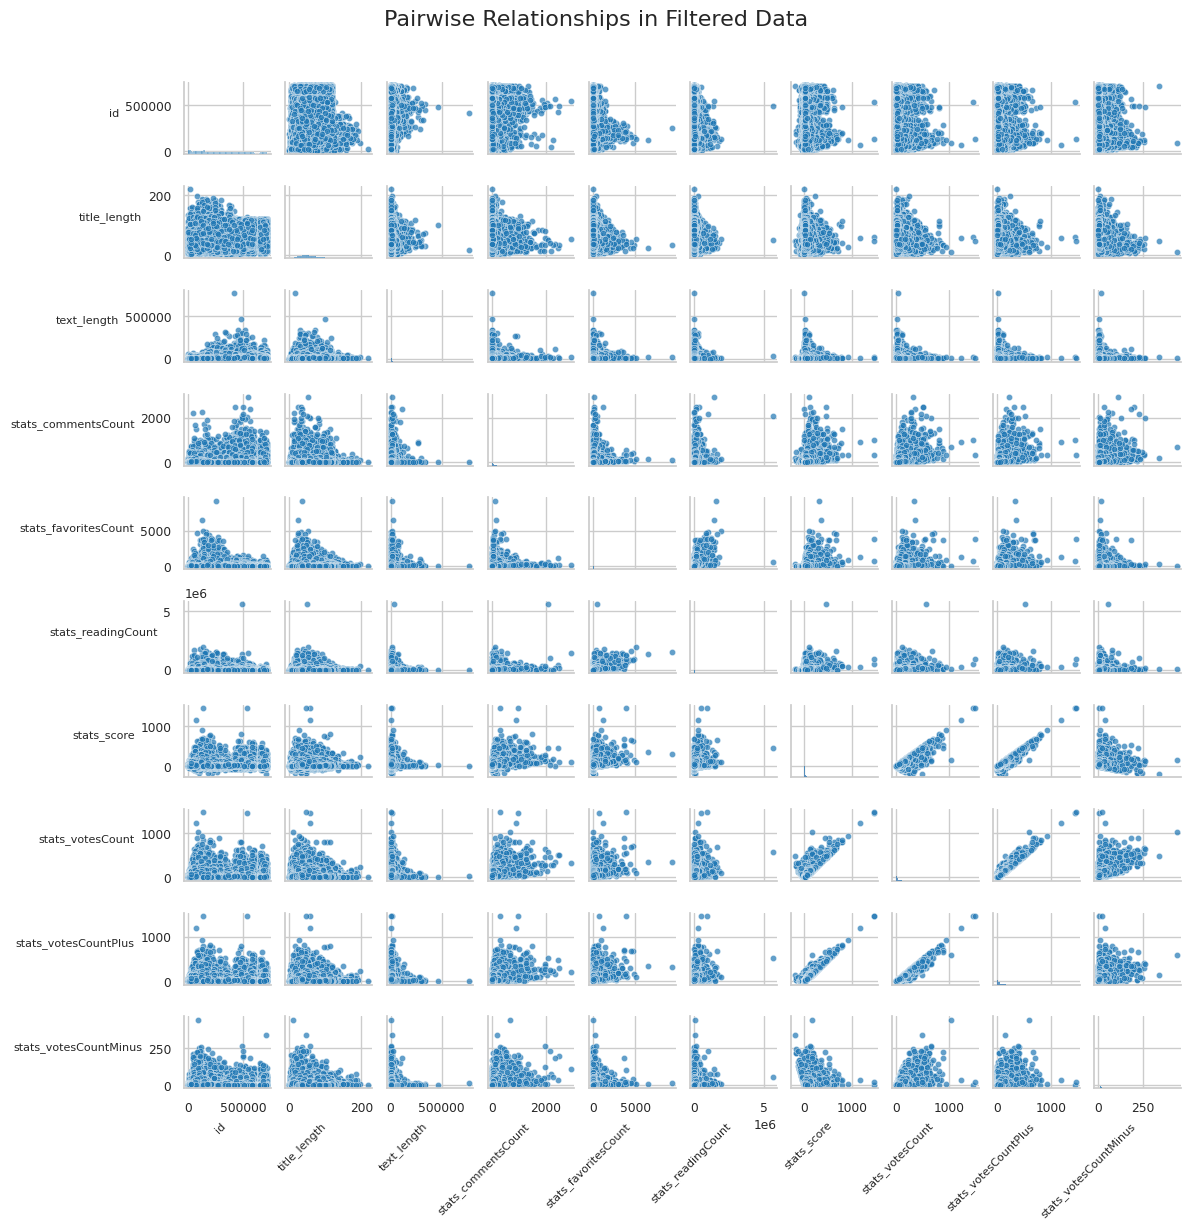

In [8]:
def draw_pairplot(df: pd.DataFrame) -> None:
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=0.8)

    pair_plot = sns.pairplot(
        df, diag_kind="hist", corner=False, plot_kws={"alpha": 0.7, "s": 20}
    )

    pair_plot.fig.set_size_inches(12, 12)

    for i, ax_row in enumerate(pair_plot.axes):
        for j, ax in enumerate(ax_row):
            if ax is not None:
                if i == len(pair_plot.axes) - 1:
                    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha="right", fontsize=8)
                if j == 0:
                    ax.set_ylabel(ax.get_ylabel(), rotation=0, ha="right", fontsize=8)

    pair_plot.fig.suptitle(
        "Pairwise Relationships in Filtered Data", fontsize=16, y=1.02
    )
    pair_plot.fig.tight_layout()

    plt.show()


draw_pairplot(filtered_df)

Let's discuss the most obvious graphs. We see almost linear dependency between `stats_score`, `stats_votesCount` and `stats_votesCountPlus` which gives us intuition how the `score` is calculated. It would be pretty useful if our goal was to predict the `stats_score`.

We can notice, that if `text_length` increases significantly, all the stats will decrease. It shows us, that most people don't read long articles on Habr. We also can notice the similar problem for `title_length`.

We can also notice some more weird points which has incredibly big values for some columns. Let's also filter them. We will excluse long texts and some suspiciously high statistics.

In [9]:
filtered_df = filtered_df[
    (filtered_df["text_length"] <= 450_000)
    & (filtered_df["stats_readingCount"] < 5_000_000)
    & (filtered_df["stats_favoritesCount"] < 5_300)
]

Let's take a look at the pairplot again.

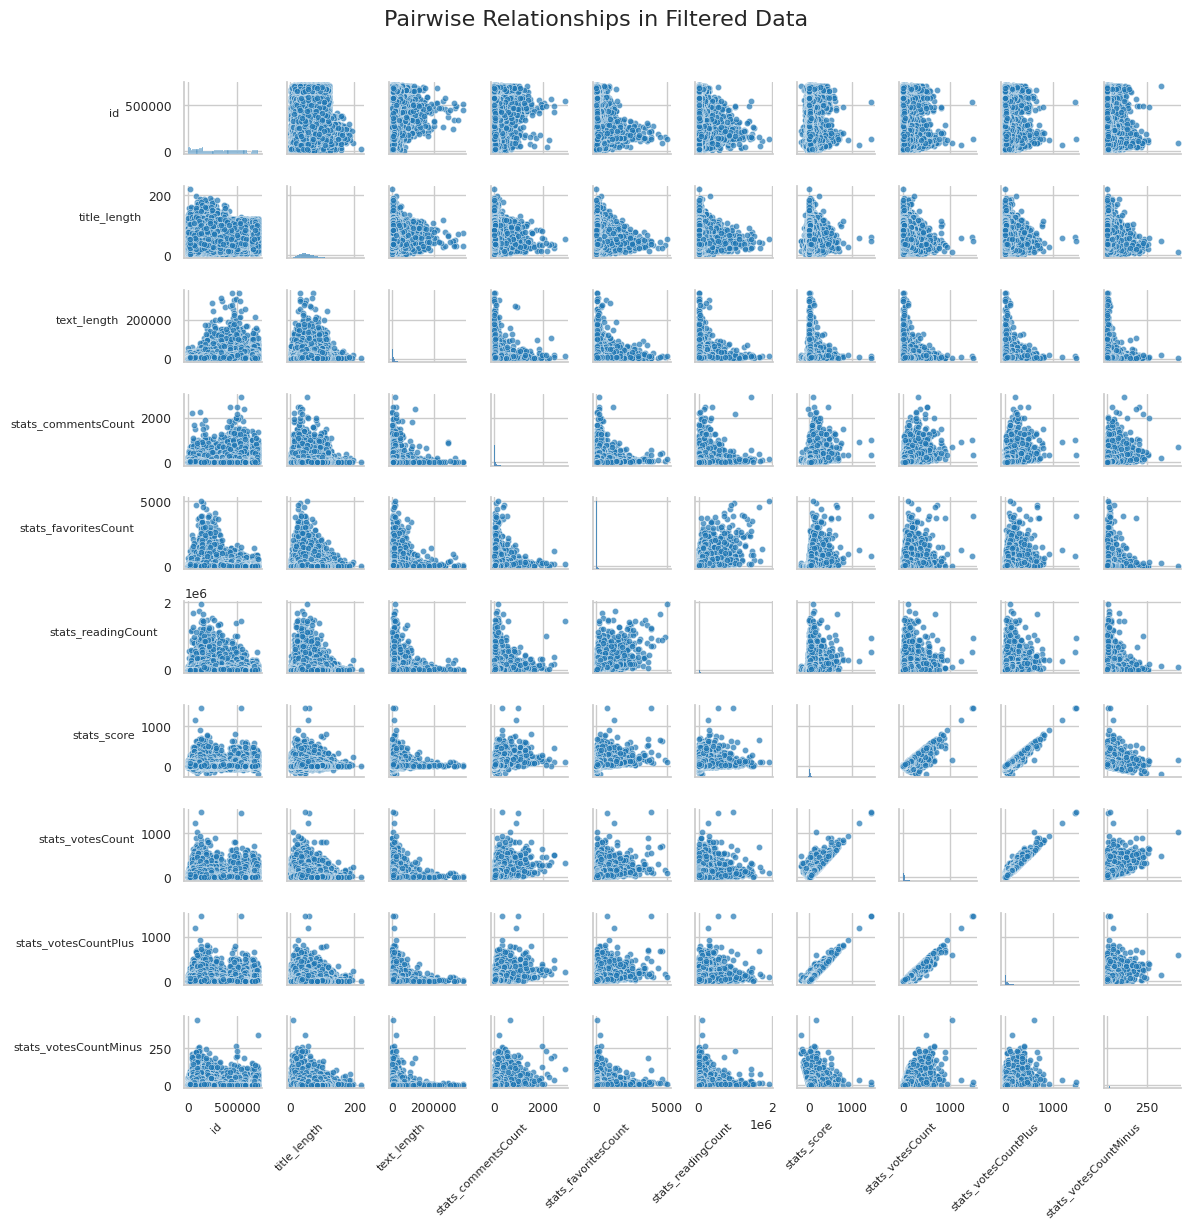

In [10]:
draw_pairplot(filtered_df)

Looks much better now. Let's save id from filtered data so we can reuse it in the future.

In [11]:
filtered_df.id.to_csv(settings.data_dir / "interim/filtered_indexes.csv")

## Other columns analysis

We already filtered the dataset based on numerical features, but let's also consider other. Our goal is to predict a hub, so we are interested in getting some knowledge about this column.

Let's set a clear purpose for such section. We will formulate it in the following two questions:

- Are the classes balanced?
- Are distrubitions for numerical features the same among different hubs?
- Does language of the article change the distributions?